### 1. A random number X is from Uniform[0, 1]. Then a sequence Y1, Y2, . . . of random numbers is chosen independently from Uniform[0, 1]. When Yi > X for the first time, you are paid (i − 1) dollars. What is the expected value of this event?

Since we assume a uniform distribution, the probability is just the length of the interval for failure. It is
 $$P \{y_i\geq x\}= 1-x $$
The expected number of trials for any fixed x is the reciprocal of the probability of the event. Thus the expected value for y is, $$ \frac{1}{(1-x)}-1 = \frac{x}{(1-x)} $$

The expected value for this event over all posible choice of x is 
$$\int_{0}^{1} \frac{x}{(1-x)} dx = -x - \ln(1-x) \Big|_{0}^{1} = \infty $$

## 2. Given a biased coin that comes up heads with some probability greater than one-half and less than one, can we use it to simulate an unbiased event?


** Simple answer is 'yes'. **

Let p as a probability of coming up heads. (0 < $p$ < 1 )

1. Flip the coin twice. 
2. If you get HT *(which happens with probability p(1 − p))*, say “Heads”. If you get TH *(which happens with the same probability (1 − p)p)*, say “Tails”. 
3. Else, you must have got HH or TT, in which case you repeat the experiment.

While there is no guarantee that you will stop after a fixed number of steps, the chance that you will require more than $k$ steps is $q^k$, 
where $q = p^2 + (1 − p)^2 < 1$ (since 0 <$p$ < 1). As $k → \infty$, this probability tends to 0, and hence you will stop with probability 1. (This trick is usually attributed to John von Neumann.)



## 3. The attached file(df.csv) includes a bitcoin price index with timestamp for some time period. Develop a statistical model, or derive any statistical inference using the df.

### 1. Descriptive Analysis
#### 1) Read the data

In [39]:
import warnings
import itertools
import pandas as pd
import numpy as np
from pandas.core import datetools
import matplotlib.pyplot as plt
from datetime import datetime
import time
plt.style.use('fivethirtyeight')

In [38]:
df= pd.read_csv('C:/Users/Jennifer/Documents/Work_Data/Project/data.csv')
df['timestamp']=[time.strftime('%m-%d %H:%M', time.localtime(x)) for x in df['timestamp']]#change the timestamp to datetime
df.set_index('timestamp', inplace=True)
df.head()  #Change the data structure with timestamp as index column

,price
timestamp,
03-22 13:40,9005.11
03-22 13:41,9007.20
03-22 13:42,9007.04
03-22 13:43,9019.51
03-22 13:44,9013.79


### 2) Plotting the Bitcoin Price Time Series

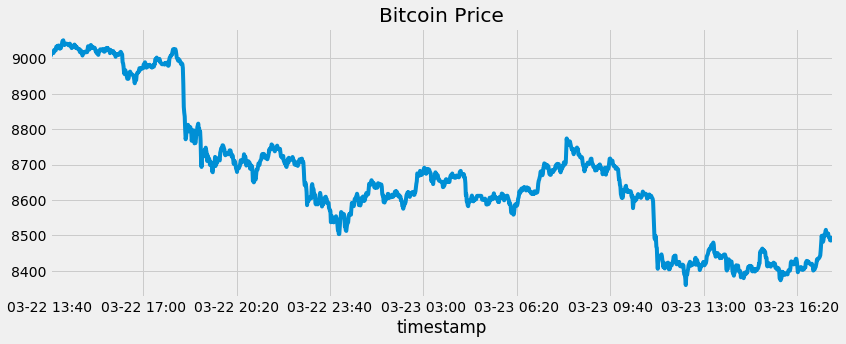

In [9]:
df.price.plot(title='Bitcoin Price', figsize=(12,5))
plt.tight_layout(); plt.show()

**Findings: 주어진 기간에서 두 번의 계단식 가격 하락이 발생하였음을 시계열 그래프를 통해 일차적으로 확인 **

### 3) Find out the '% Change' for 1 min and 30 mins : 등락폭 계산

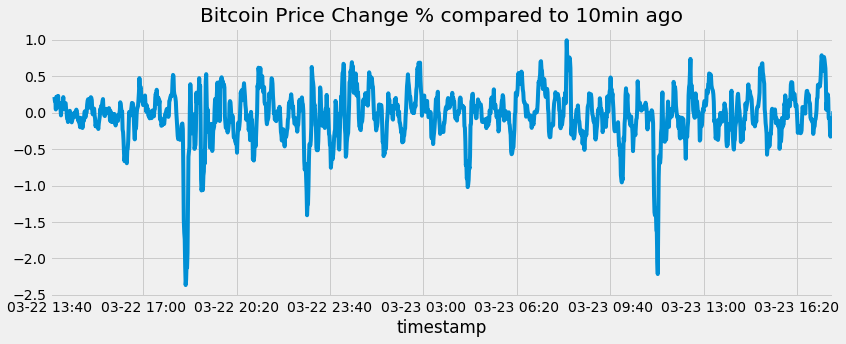

In [10]:
df['shifted']= df.price.shift()

df['diff']= df.price.diff() #1분전 대비 가격 등락폭 (absolute number)
df['pct_change_10min']=df.price.pct_change(10).mul(100)  #1분전 대비 등락 (%)
df['pct_change_30min']=df.price.pct_change(30).mul(100)  #30분전 대비 등락 (%)

df.pct_change_10min.plot(title='Bitcoin Price Change % compared to 10min ago', figsize=(12,5)) #10분전 대비 등락 그래프
plt.tight_layout(); plt.show()

In [173]:
df[df.pct_change_10min <-2]

,price,shifted,diff,pct_change_10min,pct_change_30min
timestamp,,,,,
03-22 18:30,8798.05,8836.15,-38.10,-2.116749,-2.326911
03-22 18:31,8771.75,8798.05,-26.30,-2.366011,-2.654872
03-22 18:32,8779.45,8771.75,7.70,-2.295314,-2.572016
03-22 18:33,8800.52,8779.45,21.07,-2.063337,-2.433800
03-22 18:34,8792.36,8800.52,-8.16,-2.127243,-2.585392
03-23 11:21,8427.97,8465.01,-37.04,-2.042379,-2.241789
03-23 11:22,8405.93,8427.97,-22.04,-2.214785,-2.462704


**위 그래프와 표에서 알 수 있듯이,  10분 전 가격 대비 2%이상의 큰 폭의 하락이 발생한 시점은 03-02 18:30~18:34까지, 23일 11:21분~11:22까지 총 2회 발생하였다. **

1. 22일 18시 30분에 발생한 첫 번째 가격 급락 폭은 10분 전 가격 기준 -2.11% 였으며, 30분 전 가격 기준으로는 -2.32% 였다. 1분 전 가격 대비 38.1 달러 하락하였다.

2. 23일 11시 21분에 발생한 두 번째 가격 급락 폭은 10분 전 가격 기준 -2.04% 였으며, 30분 전 가격 기준으로는 -2.24% 였다. 1분 전 가격 대비 37.04 달러 하락하였다.

### 4) Growth Rate

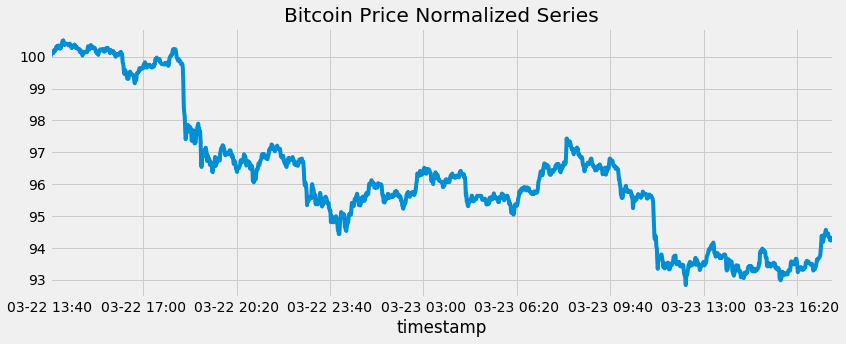

In [11]:
first_price = df.price.iloc[0]
normalized = df.price.div(first_price).mul(100)
normalized.plot(title='Bitcoin Price Normalized Series', figsize=(12,5) )
plt.tight_layout(); plt.show()

**위의 그래프는 주어진 데이터의 처음 가격을 기준(100) 으로 가격이 얼마나 상승하였는지 그린 그래프다. 가격 형성이 계단 형태로 100, 96(기준값 대비 4% 하락), 93 (기준값 대비 6% 하락) 과 같은 지지선이 존재함을 알 수 있다. **

### 5) Downsampling : Rolling Metrics

In [12]:
df= pd.read_csv('C:/Users/Jennifer/Documents/Work_Data/Project/data.csv')
df['timestamp']=[time.strftime('%Y-%m-%d %H:%M', time.localtime(x)) for x in df['timestamp']]#change the timestamp to datetime
df.set_index(pd.DatetimeIndex(df['timestamp']),inplace=True)
df=df[['price']]

In [10]:
hourly=df.resample('H').asfreq()

In [11]:
hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29 entries, 2018-03-22 13:00:00 to 2018-03-23 17:00:00
Freq: H
Data columns (total 1 columns):
price    28 non-null float64
dtypes: float64(1)
memory usage: 464.0 bytes


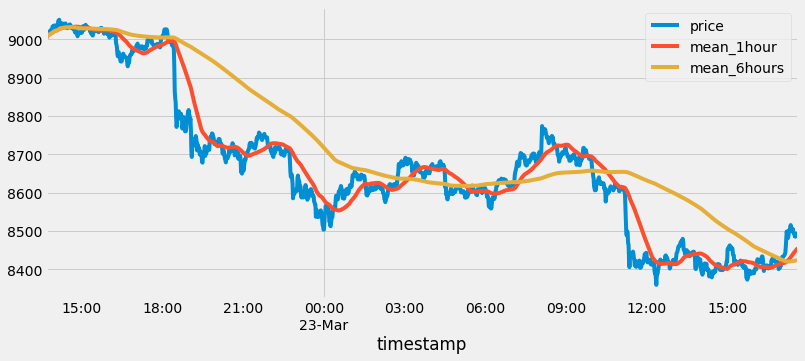

In [13]:
r90 = df['price'].rolling(window='1H').mean() 
df['mean_1hour'] = r90
r360 = df['price'].rolling(window='6H').mean()
df['mean_6hours'] = r360
df.plot(figsize=(12,5))
plt.show()

** 위 그래프는, 비트코인 가격의 1시간 평균 가격 그래프와 6시간 평균 가격 그래프로,  Rolling means (or moving averages) 숏텀 fluctuations 을 smoothing 하고 장기적 트렌드를 살펴 볼 수 있다. **

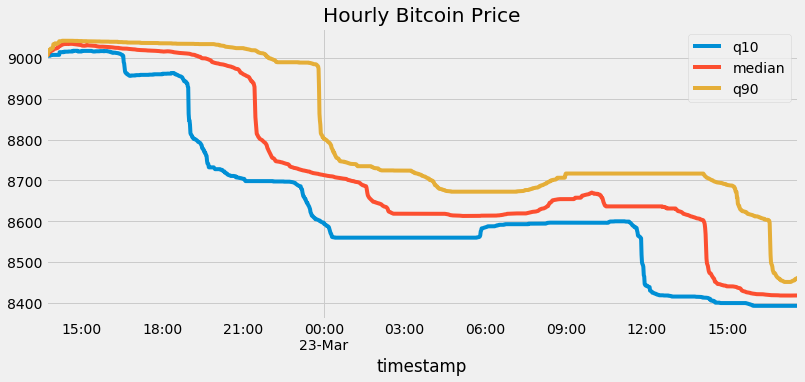

In [14]:
rolling = df.price.rolling('6H')
q10 = rolling.quantile(.1).to_frame('q10')
median = rolling.median().to_frame('median')
q90 = rolling.quantile(.9).to_frame('q90')
pd.concat([q10, median, q90], axis=1).plot(title='Hourly Bitcoin Price',figsize=(12,5))
plt.show()

** 위 그래프는 6시간 중위값(Median) 가격과 동일 기준, 상위 10%, 상위 90%의 가격을 표시한 값이다 **

### 6) Check ACF and PACF to examine the time series dependency structure (Check Stationarity)

The **Autocorrelation function (ACF)** is a function of the time displacement of the time series itself. Informally, it is the similarity between observations as a function of the time lag between them. The **Autorrelation Function (PACF)** is the conditional correlation between two variables under the assumptions that the effects of all previous lags on the time series are known.

In [46]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def adf_test(y):
    # perform Augmented Dickey Fuller test
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)

** 위의 Augmented Dickey-Fuller test 는 Stationarity (the process has a certain statistically stable structure which can be described by using a number of parameters ) 여부를 체크할 수 있는 테스트로, P-value 값이 0.05 이상으로 귀무가설 (a unit root is present in a time series sample) 을 기각하지 못한다. 즉, 해당 시계열 데이터는 non-staionarity 데이터다. **

In [26]:
adf_test(np.log(df.price)) ## transformed to log data

Results of Augmented Dickey-Fuller test:
test statistic            -1.714926
p-value                    0.423439
# of lags                 10.000000
# of observations       1668.000000
Critical Value (1%)       -3.434276
Critical Value (5%)       -2.863274
Critical Value (10%)      -2.567693
dtype: float64


**log 로 데이터를 변환하여도 ADF Test 에서 p-value 값이 0.05 이상으로 non-stationarity 특성에 변함이 없다.**

In [27]:
adf_test(np.diff(df.price)) ## transformed to the first differences

Results of Augmented Dickey-Fuller test:
test statistic         -1.381265e+01
p-value                 8.176947e-26
# of lags               9.000000e+00
# of observations       1.668000e+03
Critical Value (1%)    -3.434276e+00
Critical Value (5%)    -2.863274e+00
Critical Value (10%)   -2.567693e+00
dtype: float64


** 시계열 데이터의 First difference 로 변형하여 동일하게 ADF Test 를 하면 P-value 값이 0.05 이하로, Stationarity 데이터로 변경됨을 확인 할 수 있다. 주어진 데이터와 변형한 데이터의 stationarity 확인 그래프를 그려보면 아래와 같다. **

In [50]:
## 변형 전 시계열 데이터
def ts_plot(y, lags=None, title=''):
    '''
    Calculate acf, pacf, histogram, and qq plot for a given time series
    '''
    # if time series is not a Series object, make it so
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    # initialize figure and axes
    fig = plt.figure(figsize=(15, 10))
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    hist_ax = plt.subplot2grid(layout, (2, 1))
    
    # time series plot
    y.plot(ax=ts_ax)
    plt.legend(loc='best')
    ts_ax.set_title(title);
    
    # acf and pacf
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5) 
    
    # qq plot
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('Normal QQ Plot')
    
    # hist plot
    y.plot(ax=hist_ax, kind='hist', bins=25);
    hist_ax.set_title('Histogram');
    plt.tight_layout();
    plt.show()
    return

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


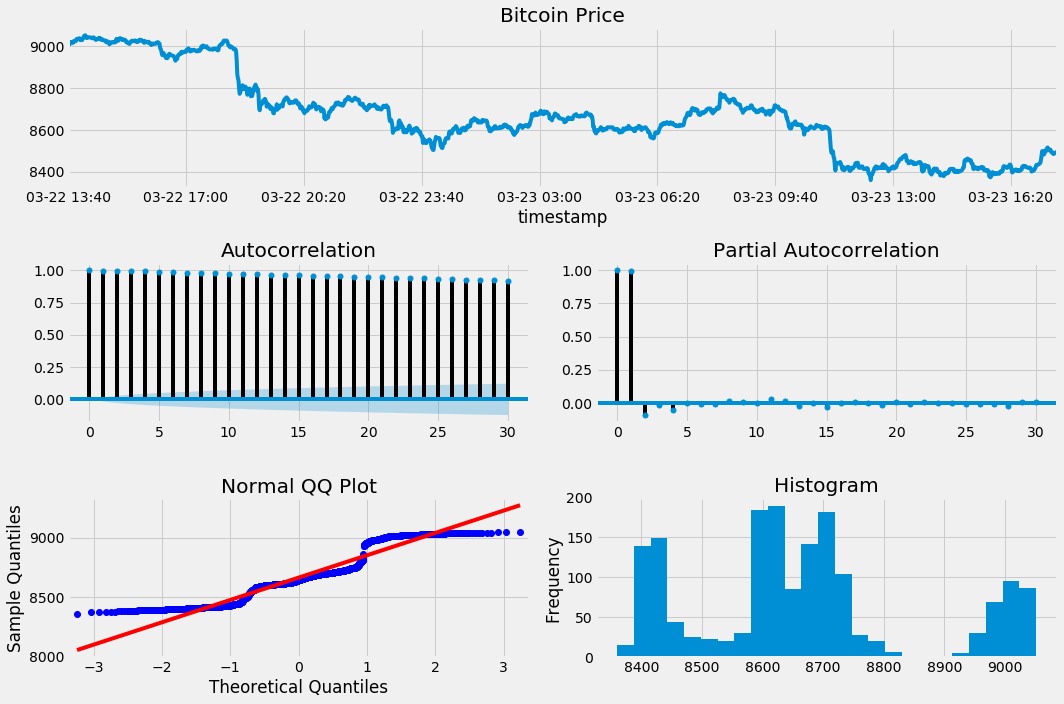

In [51]:
ts_plot(df.price, lags=30, title='Bitcoin Price')

**위의 그래프는 ACF, PACF, noraml QQ plot , 히스토그램을 그린 그래프로, 변형 전의 데이터는 random walk proccess 를 따르는 그래프임을 확인할 수 있다. Random walk 의 경우 Naive forcast (or Persistence model) 로 forcast 하는 것이 낫다. 

*참고) Random Walk Proccess is characterized by a high ACF for any lag length and a high PACF for the fist lag only. The normal QQ plot and the histogram indicate that the series is not white noise. An important characteristic of a random walk process is that is "non-stationary".* **  This means that if a given time series is assumed to be governed by a random walk process it is unpredictable.***

*참고2) The persistence method assumes that  the next time step will be a function of the prior time step.*

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


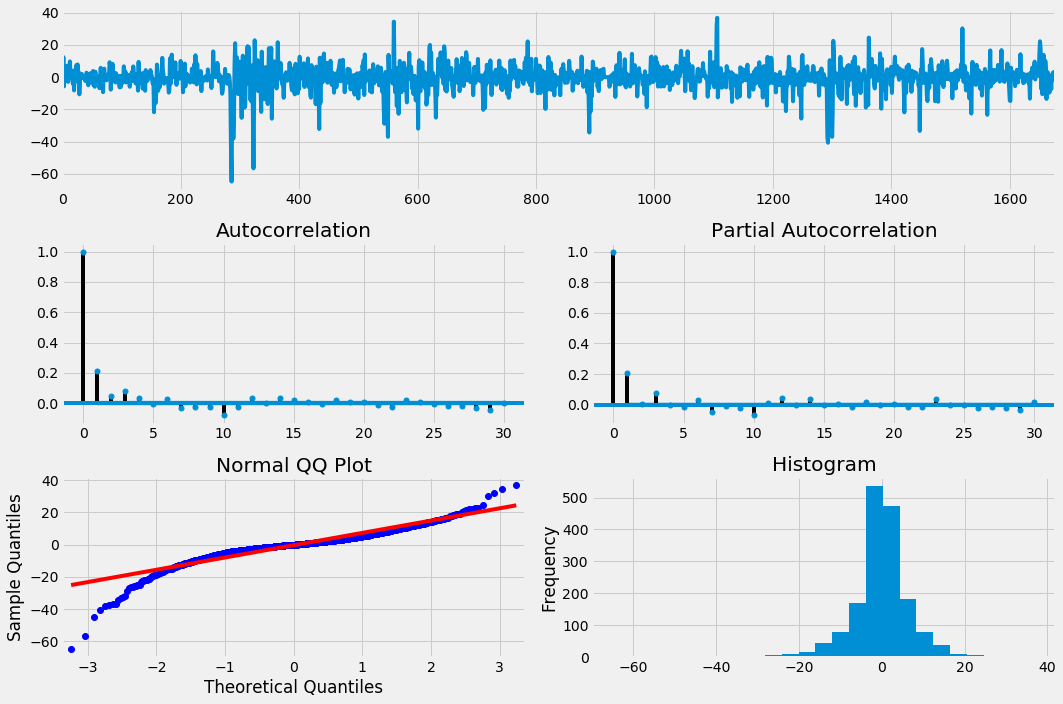

In [52]:
## first difference 로 변형한 시계열 데이터
ts_plot(np.diff(df.price), lags=30)

**First Difference 의 ACF, PACF, Normal QQ plot 의 형태를 확인하면 white noise 와 비슷하다. ** 다만, QQ plot 을 보았을 때, 정규 분포에 가깝긴 하지만 'Heavy tail' 이 존재한다. 또한 ACF 와 PACF Plot 을 보면 lag 10 에서 significant serial correlation 이 있을 것으로 보인다.

### 2. Forecast Timeseries Model Using 'Prophet'

Prophet is a procedure for forecasting time series data. **This is similar to a generalized additive model (GAM), a class of regression models with potentially non-linear smoothers applied to the regressors. **

#### 1) Read the data

In [351]:
#import rpy2.ipython
#load_ext rpy2.ipython
#matplotlib inline
from matplotlib import pyplot as plt
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from fbprophet import Prophet
import time
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

df= pd.read_csv('/Users/damee/Documents/data.csv')
df['timestamp']=[time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)) for x in df['timestamp']]   #change the timestamp to datetime
df.rename(columns={'timestamp': 'ds','price':'y'}, inplace=True)   #change the column name from 'timestamp' to 'datetime'

#### 2) Predict 
The predict method will assign each row in future a predicted value which it names **yhat**. If you pass in historical dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and **uncertainty intervals**.

In [4]:
m = Prophet(changepoint_prior_scale = 0.005)
m.fit(df);
future = m.make_future_dataframe(periods=60*3, freq='1min')  #180분 뒤까지의 가격 예측
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1854,2018-03-23 20:34:00,8441.110236,8287.096457,8596.623524
1855,2018-03-23 20:35:00,8441.156184,8289.101622,8596.951493
1856,2018-03-23 20:36:00,8441.202133,8280.679766,8605.304474
1857,2018-03-23 20:37:00,8441.248081,8287.791408,8604.167850
1858,2018-03-23 20:38:00,8441.294029,8285.923266,8612.616904


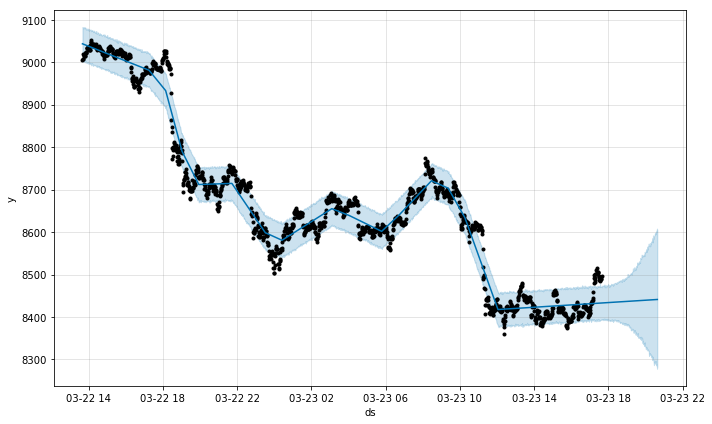

In [64]:
m.plot(forecast);

주어진 데이터의 기간이 충분히 길지 않아, trend 와 seasonality 를 decompositon 하기 어려우나 해당 모델을 통해, 파란색 색 선과 같은 예측 값을 얻을 수 있다. 하늘색 영역은 예측치(yhat) 의 95% 신뢰 구간 영역을 표시한다.